Import libraries

In [2]:
!pip install seaborn==0.11.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 283.1/283.1 kB 8.7 MB/s eta 0:00:00
  Attempting uninstall: seaborn
    Found existing installation: seaborn 0.12.2
    Uninstalling seaborn-0.12.2:
      Successfully uninstalled seaborn-0.12.2


In [1]:
from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from plotly import __version__
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 
import plotly.offline as pyo
import plotly.graph_objs as go
from plotly.offline import iplot
from scipy import stats
import math
import pandas as pd
#import ipywidgets
from scipy.optimize import curve_fit
#import plotly.express as px
from numpy import mean, std

#from plotnine import ggplot, aes, geom_point, geom_smooth, facet_wrap, scale_x_continuous, scale_y_continuous
#from plotnine.data import mpg

Import data paths

In [4]:
# Data paths
path="/content/drive/MyDrive/MyReposDrive/expectation_time/Expectation_Shapes_Perceived_Time/data/"
data_Erva="erva50_pilot_base_expectation_shapes_perceived_time_2023-03-16_23h46.19.804.csv" # no expectation
data_Erva_70="erva07_expectation_shapes_perceived_time_2023-03-23_20h55.33.677.csv"
data_Erva80="erva80G_expectation_shapes_perceived_time_2023-04-07_23h25.04.855.csv"

data_nicola_85_1="nicola_85_1_expectation_shapes_perceived_time_2023-03-28_15h04.34.263.csv"
data_Nicola=  'nicola_base_pilot_expectation_shapes_perceived_time_2023-03-20_15h03.16.305.csv'# no expectation

data_Omer="299271_expectation_shapes_perceived_time_2023-03-19_15h42.48.633.csv" # no expectation
data_Omer2="omer85_high_exp_expectation_shapes_perceived_time_2023-03-17_12h35.14.339.csv" # expectation
data_omer_70="omer70_expectation_shapes_perceived_time_2023-03-27_21h43.36.152.csv" #expected 70 percent
data_omer_80G="omer80G_expectation_shapes_perceived_time_2023-04-03_14h30.36.416.csv" #expected 80 percent

data_elaine80R="elaine08R_expectation_shapes_perceived_time_2023-04-13_17h14.41.421.csv" #expected 80 percent

data_marika="marika_expectedh2_expectation_shapes_perceived_time_2023-04-28_16h29.23.427.csv"

data_ahmed_high="ahmed_high0_cont_expectation_shapes_perceived_time_2023-04-29_14h47.24.687.csv"
data_ahmed_base="ahmed_base01_expectation_shapes_perceived_time_2023-04-29_13h16.43.447.csv"

data_sarah_base="sarah_base0_expectation_shapes_perceived_time_2023-04-29_15h33.10.161.csv"
data_sarah_high="sarah_high1_expectation_shapes_perceived_time_2023-04-29_16h58.53.797.csv"
datas_expecataions_80=[data_Erva80,data_omer_80G,data_elaine80R,data_marika,data_sarah_high,data_ahmed_high,data_ahmed_base,data_sarah_base]

#### 0 - Select specific columns

In [5]:
def clean_data(datam):
    try:
        datam["delayS"]=datam["delay"]/1000
    except KeyError:
        pass
    datam["pTemporalError"]=datam["perceivedTime"]-datam["target.started"]# Calculate temporalError
    datam["pTemporalErrorMs"]=datam["pTemporalError"]*1000
    try:   
        datam["physicalDelay"]=datam["distractor.started"]-datam["target.started"]
    except KeyError: 
        pass
    datam["physicalDelayMs"]=datam["physicalDelay"]*1000
    datam["rt_total"]=datam["responsePointer.stopped"]-datam["responsePointer.started"]
    #except KeyError:
        #print("already cleaned "+str(datam["date"][0]))
    return datam


#### Find outliers  and predicted perceived time 


In [202]:
xAxisTicks=[-0.300 , -0.233, -0.167, -0.100 , -0.033, 0.033, 0.100 ,0.167, 0.233, 0.300]
def outlier_remover(data,variable):
    mean_tmp, std_tmp=data[variable].median(), data[variable].std()
    q1, q3= np.percentile(data["pTemporalError"],[25,75])
    iqr = q3 - q1
    rows_to_delete_lower = data[data["pTemporalError"]<mean_tmp-3*std_tmp].index
    rows_to_delete_upper = data[data["pTemporalError"]>mean_tmp+3*std_tmp].index
    #rows_to_delete_lower = data[data["pTemporalError"]<q1 -(1.5 * iqr) ].index
    #rows_to_delete_upper = data[data["pTemporalError"]>q3 +(1.5 * iqr) ].index
    #rows_to_delete_lower = q1 -(1.5 * iqr) 
    #rows_to_delete_upper = q3 +(1.5 * iqr) 
    data = data.drop(rows_to_delete_lower)
    data = data.drop(rows_to_delete_upper)
    return data
def clean_na(dfo):
    dfo=dfo[dfo["perceivedTime"].notna()]
    dfo=dfo[dfo["target.started"].notna()]
    dfo=dfo[dfo["pTemporalError"].notna()]
    unique_delays=dfo["delayS"].unique()
    dfo_tmp = pd.DataFrame(columns=["rt_total","delay","perceivedTime","pTemporalErrorMs","pTemporalError","delayS","physicalDelay","physicalDelayMs","target.started","distractor.started","participant","congruency","expectation",
             "isTrial","participant","stim_color","responsePointer.started","responsePointer.stopped","responseStarted","rtUntillMotionTreshold","rTAfterMotionTreshold"])
    if len(unique_delays)>8:
        for i in unique_delays:
            dfo_tmp_0=outlier_remover(dfo[dfo["delayS"]==i],"pTemporalError")
            dfo_tmp = pd.concat([dfo_tmp, dfo_tmp_0], ignore_index=True)
        dfo=dfo_tmp
    else:
        dfo=outlier_remover(dfo,"pTemporalError")

    return dfo
def modelPerceivedTime(targetTime,alpha,beta):
    #return alpha*(np.sin(math.pi*x))+beta*x
    y=[alpha*(np.sin(math.pi*x))+beta*x for x in targetTime]
    return y
def modelPerceivedTime2(x,alpha,beta):
    #return alpha*(np.sin(math.pi*x))+beta*x
    return alpha*(np.sin(math.pi*x))+beta*x

def predictedPerceivedTime(dfo): 
    #df=df[df["isTrial"]=="trial"]
    # dfo=dfo[dfo["perceivedTime"].notna()]
    # dfo=dfo[dfo["target.started"].notna()]
    # dfo=dfo[dfo["pTemporalError"].notna()]
    # dfo=outlier_remover(dfo,"pTemporalError")
    # fit training
    x=np.float64(dfo["target.started"])
    y=np.float64(dfo["perceivedTime"])
    params_train, covariance_train = curve_fit(modelPerceivedTime2, x, y)
    modelPreditcedPerceivedTime = modelPerceivedTime2(dfo["target.started"], params_train[0], params_train[1])
    ## assign new variables to df
    dfo["predictedPerceivedTime"]=modelPreditcedPerceivedTime # take fitted perceived time to the data
    dfo["pTemporalErrorFitted"]=dfo["perceivedTime"]-dfo["predictedPerceivedTime"] # calculate temporal error based on predicted time
    return dfo,params_train,covariance_train

def fitPerceivedTime(dfo):
    x=np.float64(dfo["target.started"])
    y=np.float64(dfo["perceivedTime"])
    params_train, covariance_train = curve_fit(modelPerceivedTime2, x, y)
    modelPreditcedPerceivedTime = modelPerceivedTime2(dfo["target.started"], params_train[0], params_train[1])
    return params_train,covariance_train

def fit_assign(dfo):
    #dfo=clean_na(dfo)
    param_train,cov_test=fitPerceivedTime(dfo)
    modelPreditcedPerceivedTime = modelPerceivedTime2(dfo["target.started"], param_train[0], param_train[1])
    dfo["predictedPerceivedTime"]=modelPreditcedPerceivedTime
    dfo["pTemporalErrorFitted"]=dfo["perceivedTime"]-dfo["predictedPerceivedTime"] # calculate temporal error based on predicted time
    return dfo


# Gather overerall data for analysis

In [203]:
#os.chdir("D:/analysis/")
os.listdir()
import glob
#os.listdir("data/")
# specifying the path to csv files
path = "/content/drive/MyDrive/MyReposDrive/expectation_time/Expectation_Shapes_Perceived_Time/data"
os.chdir(path)
# csv files in the path
files = glob.glob("*.csv")

# create a blank dataframe with column names
datas = pd.DataFrame(columns=["rt_total","delay","perceivedTime","pTemporalErrorMs","pTemporalError","delayS","physicalDelay","physicalDelayMs","target.started","distractor.started","participant","congruency","expectation",
             "isTrial","participant","stim_color","responsePointer.started","responsePointer.stopped","responseStarted","rtUntillMotionTreshold","rTAfterMotionTreshold"])
datas_participant = pd.DataFrame(columns=["rt_total","delay","perceivedTime","pTemporalErrorMs","pTemporalError","delayS","physicalDelay","physicalDelayMs","target.started","distractor.started","participant","congruency","expectation",
             "isTrial","participant","stim_color","responsePointer.started","responsePointer.stopped","responseStarted","rtUntillMotionTreshold","rTAfterMotionTreshold"])

data_paths=[]
for i in range(1,15):
    participant_files = glob.glob("p"+str(i)+"_*")
    data_paths.append(participant_files)
# file_paths=[i.split('/')[-1] for i in files]
# file_path_nums=[int(i.split('_')[0][1:])-1 for i in file_paths]
files = glob.glob("*.csv")

for data_participants in data_paths:
    datas_participant = pd.DataFrame(columns=["rt_total","delay","perceivedTime","pTemporalErrorMs","pTemporalError","delayS","physicalDelay","physicalDelayMs","target.started","distractor.started","participant","congruency","expectation",
             "isTrial","participant","stim_color","responsePointer.started","responsePointer.stopped","responseStarted","rtUntillMotionTreshold","rTAfterMotionTreshold"])
    for data in data_participants:
        df_tmp=pd.read_csv(data)
        try:
            df_tmp=clean_data(df_tmp)
            # select only the relevant columns
            df_tmp=df_tmp[["rt_total","delay","perceivedTime","pTemporalErrorMs","pTemporalError","delayS","physicalDelay","physicalDelayMs","target.started","distractor.started","participant","congruency","expectation",
                "isTrial","participant","stim_color","responsePointer.started","responsePointer.stopped","responseStarted","rtUntillMotionTreshold","rTAfterMotionTreshold"]]
            # row bind the dataframes
            datas_participant = pd.concat([datas_participant, df_tmp], ignore_index=True)
        except KeyError:
            print("already cleaned "+str(df_tmp["date"][0]))
    # slice the data to get only the trials wiah met and unmet congruency
    datas_test=datas_participant[datas_participant["isTrial"]=="trial"]
    datas_training=datas_participant[datas_participant["isTrial"]=="testSingleStim"]

    datas_test_met=datas_test[datas_test["congruency"]=="met"]
    datas_test_unmet=datas_test[datas_test["congruency"]=="unmet"]
    datas_test_base=datas_test[datas_test["congruency"]=="none"]
    datas_test_expected=pd.concat([datas_test_met,datas_test_unmet],ignore_index=True)

    datas_training=clean_na(datas_training)
    datas_test_expected=clean_na(datas_test_expected)
    datas_test_base=clean_na(datas_test_base)
    datas_participant=pd.concat([datas_training,datas_test_expected,datas_test_base],ignore_index=True)

    datas = pd.concat([datas, datas_participant], ignore_index=True)


# slice the data to get only the trials wiah met and unmet congruency
datas_test=datas[datas["isTrial"]=="trial"]
# datas_test=datas_test[datas_test["perceivedTime"].notna()]
# datas_test=datas_test[datas_test["target.started"].notna()]
# datas_test=datas_test[datas_test["pTemporalError"].notna()]
datas_training=datas[datas["isTrial"]=="testSingleStim"]

datas_test_met=datas_test[datas_test["congruency"]=="met"]
datas_test_unmet=datas_test[datas_test["congruency"]=="unmet"]
datas_test_base=datas_test[datas_test["congruency"]=="none"]
datas_test_expected=pd.concat([datas_test_met,datas_test_unmet],ignore_index=True)

datas_training=fit_assign(datas_training)
datas_test_expected=fit_assign(datas_test_expected)
datas_test_base=fit_assign(datas_test_base)


datas_test_met=datas_test_expected[datas_test_expected["congruency"]=="met"]
datas_test_unmet=datas_test_expected[datas_test_expected["congruency"]=="unmet"]
datas_test_expected=pd.concat([datas_test_met,datas_test_unmet],ignore_index=True)


datas=pd.concat([datas_training,datas_test_base,datas_test_expected],ignore_index=True)





In [208]:
# Get summary statistics
def get_summary_statistics(df_trial,variable="pTemporalErrorFitted"):
    df_summary=df_trial.groupby("congruency").agg({variable:["mean","std","median","sem","count","median"]})
    df_summary.columns=["mean","std","median","sem","count","median"]
    df_summary["congruency"]=df_summary.index
    df_summary["congruency"]=df_summary["congruency"].replace({"met":"Met Expectation","unmet":"Unmet Expectation"})
    return df_summary
df_summary=get_summary_statistics(datas_test_expected)
df_summary


,mean,std,median,sem,count,median,congruency
congruency,,,,,,,
met,0.005528,0.374202,0.019953,0.005018,5561,0.019953,Met Expectation
unmet,0.031030,0.376887,0.042781,0.010109,1390,0.042781,Unmet Expectation


In [215]:
#get_summary_statistics(datas_test_expected,)
get_summary_statistics(datas_test_expected,"rTAfterMotionTreshold")
#get_summary_statistics(datas_test_expected,"rtUntillMotionTreshold")
#get_summary_statistics(datas_test_base,"rTAfterMotionTreshold")



,mean,std,median,sem,count,median,congruency
congruency,,,,,,,
met,1.472568,1.520160,1.083960,0.020385,5561,1.083960,Met Expectation
unmet,1.445840,0.971184,1.141539,0.026049,1390,1.141539,Unmet Expectation


## 1- Perceived time as a function of Presentation time

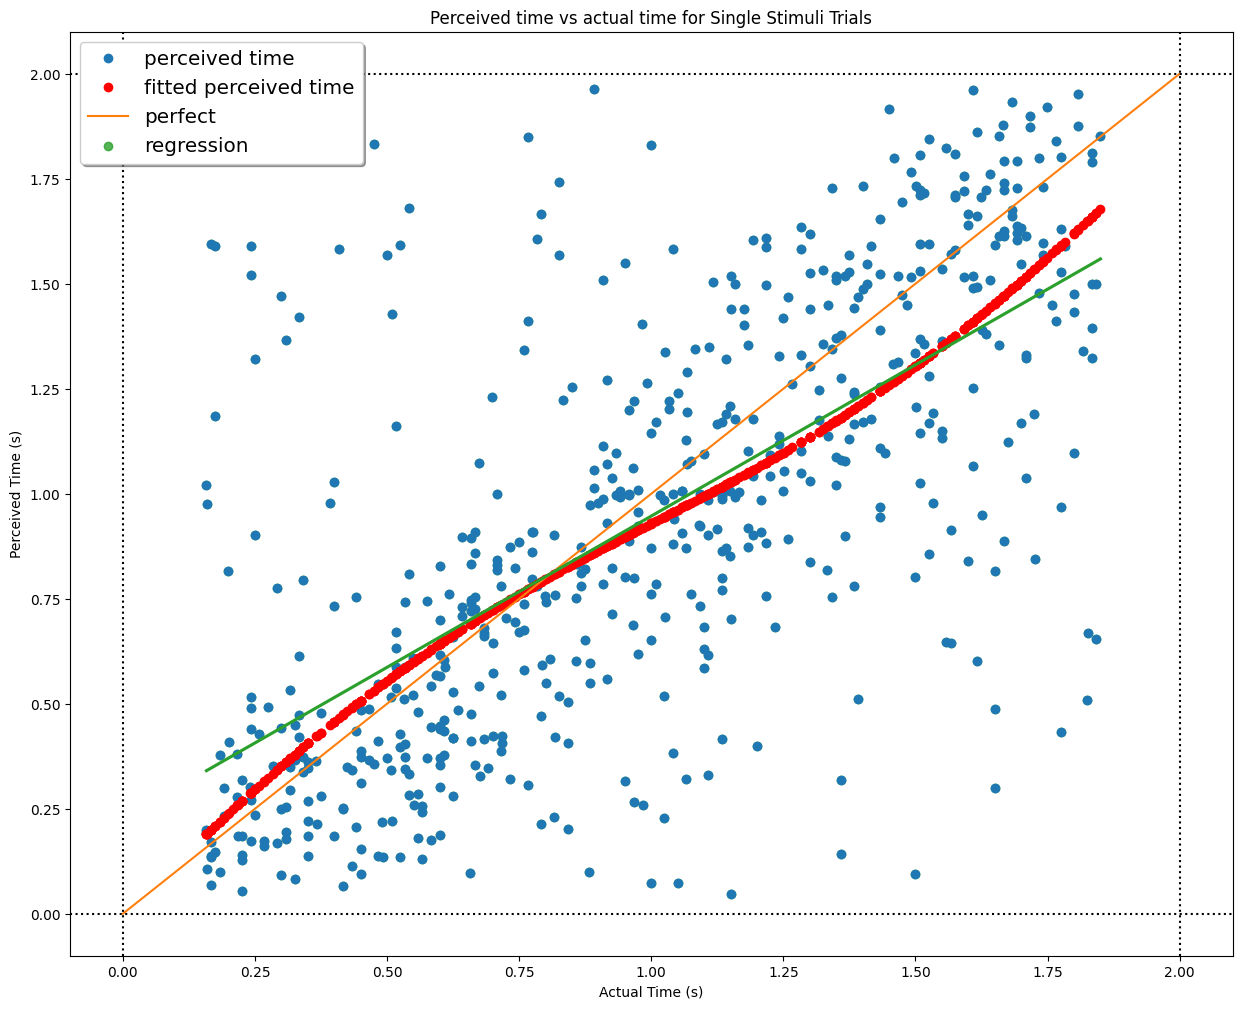

In [189]:
def plot_perceived_actual(df_trial):
    plt.figure(figsize=(15, 12))
    plt.plot(df_trial["target.started"],df_trial["perceivedTime"],'o',label="perceived time")
    plt.plot(df_trial["target.started"],df_trial["predictedPerceivedTime"],'ro',label="fitted perceived time")
    plt.plot(np.linspace(0,2,100),np.linspace(0,2,100),label="perfect")
    sns.regplot(df_trial["target.started"],df_trial["perceivedTime"], ci=None,label="regression")
    plt.axvline(x=0, color='black', linestyle='dotted')
    plt.axhline(y=0, color='black', linestyle='dotted')
    plt.axvline(x=2, color='black', linestyle='dotted')
    plt.axhline(y=2, color='black', linestyle='dotted')
    plt.title("Perceived time vs actual time for Single Stimuli Trials")
    plt.ylabel("Perceived Time (s)")
    plt.xlabel("Actual Time (s)")
    legend = plt.legend(loc='upper left', shadow=True, fontsize='x-large')
plot_perceived_actual(datas_training)


## 2.Overall Temporal Error

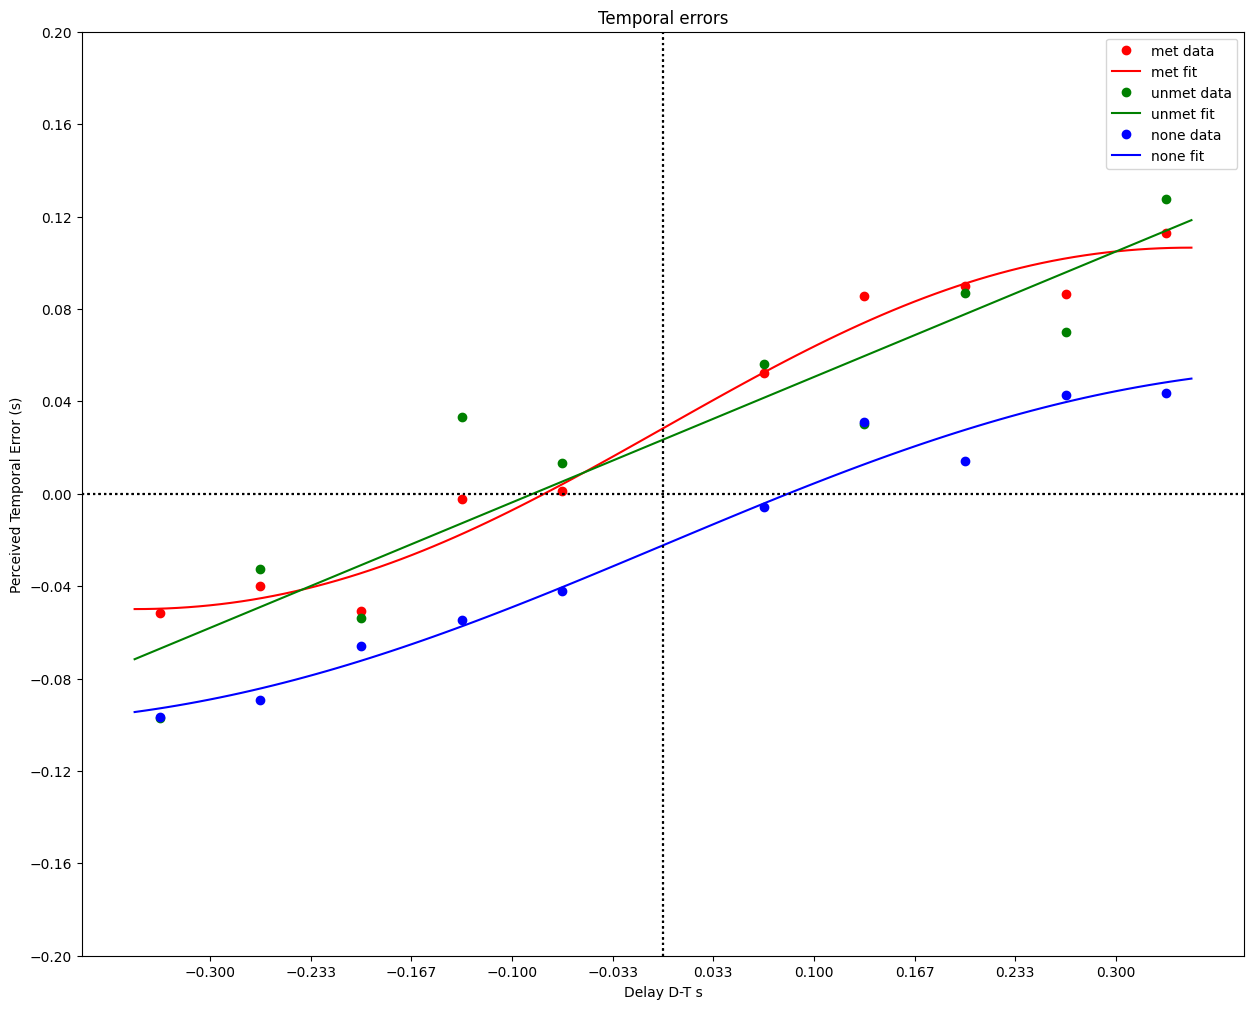

In [184]:
# Get meaans grouped by constant target-distractor delay
def get_medians(data):
    #df=clean_data(data=data_Erva)
    df_medians=data.groupby('delayS').median()
    df_stdDev=data.groupby("delayS").std()
    a=list(df_medians["delay"].unique())
    a.sort()
    df_medians["delayMs"]=a
    del a
    xdata=df_medians["physicalDelay"]
    ydata=df_medians["pTemporalErrorFitted"]
    return xdata, ydata
    
def modelPTime(delay,alpha,sigma,teta):
    modelPerceivedError=[alpha*(x/sigma)*math.exp(-(x**2)/sigma**2)+teta for x in delay]
    return modelPerceivedError

def model_time_base(delay,alpha,sigma):
    modelPerceivedError=[alpha*(x/sigma)*math.exp(-(x**2)/sigma**2) for x in delay]
    return modelPerceivedError

## plot the model
def plot_base_model(medians,df_trial,color):
    if medians==True:      xdata,ydata=get_medians(df_trial)
    else:        xdata,ydata=df_trial["physicalDelay"],df_trial["pTemporalErrorFitted"]
    #parameters, covariance = curve_fit(model_time_base, xdata, ydata)
    parameters, covariance = curve_fit(modelPTime, xdata, ydata)
    middleInt=np.linspace(-0.35,0.35,100)
    fit_k = modelPTime(middleInt, parameters[0],parameters[1],parameters[2])
    #plt.figure(figsize=(15, 12))
    # label most occuring congruency
    label=df_trial["congruency"].value_counts().index[0]
    if medians==1:
      plt.plot(xdata, ydata, 'o', label=str(label)+' data',color=color)
    plt.plot(middleInt, fit_k, '-', label=str(label)+' fit',color=color)
    plt.axvline(x=0, color='black', linestyle='dotted')
    plt.axhline(y=0, color='black', linestyle='dotted')
    #sns.regplot(xdata, ydata, ci=None,label=str(label)+" regression")
    plt.title("Temporal errors")
    plt.ylabel("Perceived Temporal Error (s)")
    plt.xlabel("Delay D-T s")
    ylim=0.2
    plt.ylim(-ylim,ylim)
    plt.yticks(list(np.linspace(-ylim,ylim,11)))
    plt.xticks(xAxisTicks)
    plt.legend()
    SE = np.sqrt(np.diag(covariance))
    SE_A , SE_B= SE[0], SE[1]
    #print(F'The value of A is {fit_A:.5f} with standard error of {SE_A:.5f}.')
    #print(F'The value of B is {fit_B:.5f} with standard error of {SE_B:.5f}.')
plt.figure(figsize=(15, 12))
plot_base_model(medians=1,df_trial=datas_test_met,color="red")
plot_base_model(medians=1,df_trial=datas_test_unmet,color="green")
plot_base_model(medians=1,df_trial=datas_test_base,color="blue")

In [171]:

def model_time_base(delay,alpha,sigma):
	modelPerceivedError=[alpha*(x/sigma)*math.exp(-(x**2)/sigma**2) for x in delay]
	return modelPerceivedError
def modelPTime(delay,alpha,sigma,teta):
    modelPerceivedError=[alpha*(x/sigma)*math.exp(-(x**2)/sigma**2)+teta for x in delay]
    return modelPerceivedError
def model_expectation_met(delay,alpha,sigma,delta,teta):
    modelPerceivedError=[alpha*(x/sigma)*math.exp(-(x**2)/sigma**2)+delta*(x**4)+teta for x in delay]
    return modelPerceivedError
def model_expectation_unmet(delay,alpha,sigma,teta,delta=1):
    modelPerceivedError=[alpha*(x/sigma)*math.exp(-(x**2)/sigma**2)+delta*(x**5)+teta for x in delay]
    return modelPerceivedError    


## fit model to to perceived time

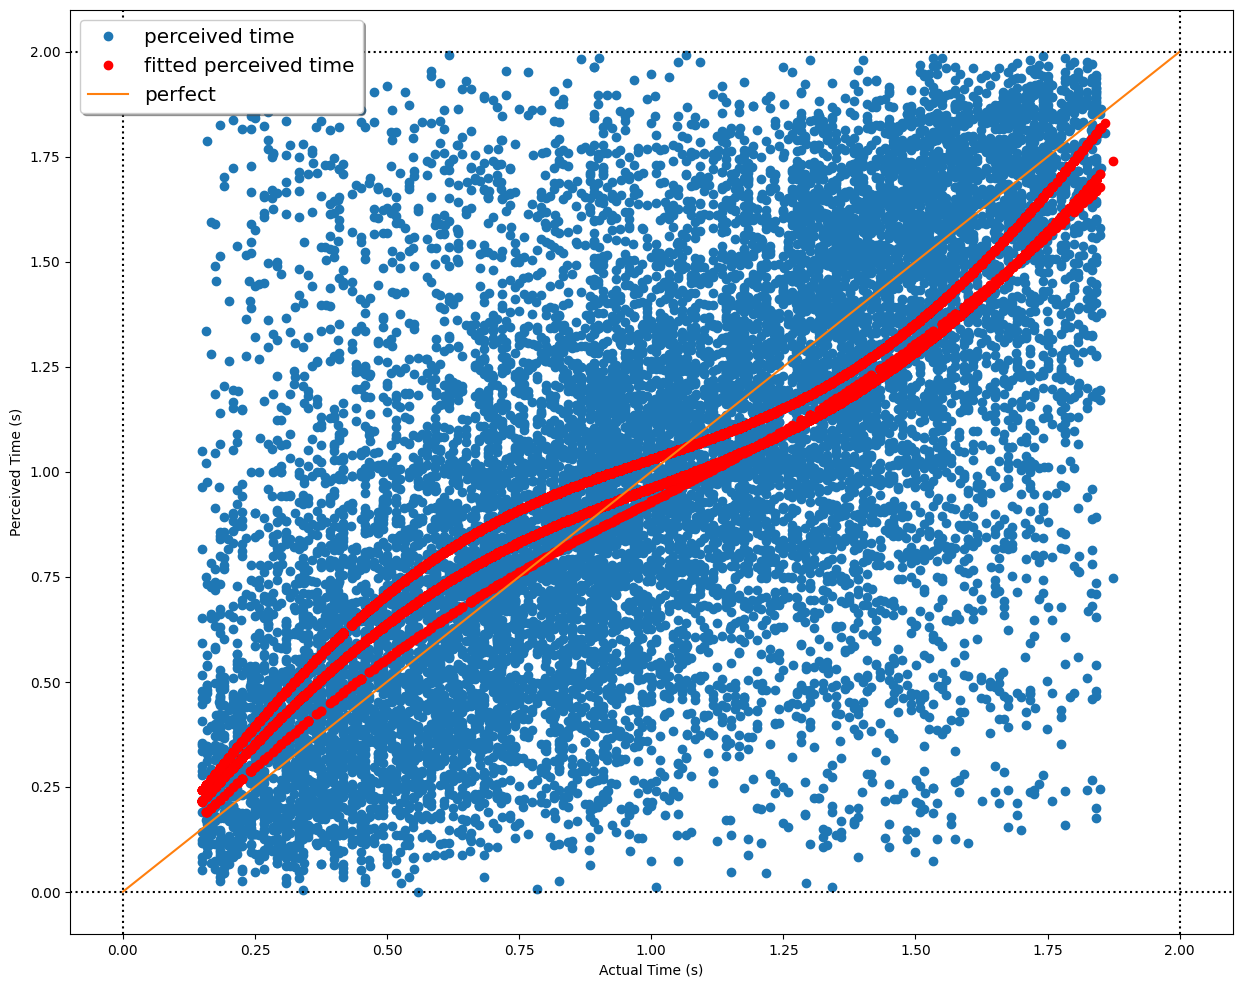

In [141]:
def modelPerceivedTime(x,alpha,beta):
    return alpha*np.sin(1*math.pi*x)+beta*x

def plot_perceived_actual(df_trial):
    plt.figure(figsize=(15, 12))
    plt.plot(datas["target.started"],datas["perceivedTime"],'o',label="perceived time")
    plt.plot(datas["target.started"],datas["predictedPerceivedTime"].astype(float),'ro',label="fitted perceived time")
    plt.plot(np.linspace(0,2,100),np.linspace(0,2,100),label="perfect")
    #sns.regplot(datas["target.started"],datas["perceivedTime"].astype, ci=None,label="regression")
    plt.axvline(x=0, color='black', linestyle='dotted')
    plt.axhline(y=0, color='black', linestyle='dotted')
    plt.axvline(x=2, color='black', linestyle='dotted')
    plt.axhline(y=2, color='black', linestyle='dotted')
    #plt.title("Perceived time vs actual time for Test trials of "+datas.split('_')[0])
    plt.ylabel("Perceived Time (s)")
    plt.xlabel("Actual Time (s)")
    legend = plt.legend(loc='upper left', shadow=True, fontsize='x-large')
plot_perceived_actual(datas)